# Initial Setup

## Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier

import re

In [2]:
from sklearn import __version__ as sklearn_version
from platform import python_version 
from matplotlib import __version__ as mp_version

print("python version:  ", python_version())
print("nltk version:    ", nltk.__version__)
print("pandas version:  ", pd.__version__)
print("numpy version:   ", np.__version__)
print("sklearn version: ", sklearn_version)
print("matplotlib version:  ", mp_version)


python version:   3.9.7
nltk version:     3.6.7
pandas version:   1.3.3
numpy version:    1.20.3
sklearn version:  1.0.2
matplotlib version:   3.4.3


Package versions used:

```
python version:   3.9.7
nltk version:     3.6.7
pandas version:   1.3.3
numpy version:    1.20.3
sklearn version:  1.0.2
matplotlib version:   3.4.3
```

## Setting Variables

In [3]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 128

In [4]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

## Loading Data

In [5]:
url1 = './data/dev_set.txt'
dev_set = pd.read_csv(url1, delimiter='\t')

In [6]:
url2 = './data/training_set.txt'
train_set = pd.read_csv(url2, delimiter='\t')

In [7]:
url3 = './data/test_set.txt'
test_set = pd.read_csv(url3, delimiter='\t')

# Baseline Preprocessing

In [8]:
## Uncomment these on first run
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')


In [9]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmd_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmd_tokens)

def text_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words in pipeline instead of in preprocessing
        - use lemmatizing instead of stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
        
    ## Use Lemmatizer
    df[col] = df[col].apply(lambda x: lemmatize_sentences(x) )
    
    ## Remove excess spaces
    df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    df[col] = df[col].str.strip()
    
    return df

In [11]:
train_set_prep = text_preprocessing(train_set, 'sentence', stop)

In [12]:
dev_set_prep = text_preprocessing(dev_set, 'sentence', stop)

In [13]:
test_set_prep = text_preprocessing(dev_set, 'sentence', stop)

# Data Understanding

In [14]:
labels = {
    1: 'Anger',
    2: 'Anticipation',
    3: 'Digust',
    4: 'Fear',
    5: 'Joy',
    6: 'Sadness',
    7: 'Surprise',
    8: 'Trust',
}

In [15]:
X_train = train_set_prep['sentence']
Y_train = train_set_prep['emotion']

X_dev = dev_set_prep['sentence']
Y_dev = dev_set_prep['emotion']

X_test = test_set_prep['sentence']
Y_test = test_set_prep['emotion']

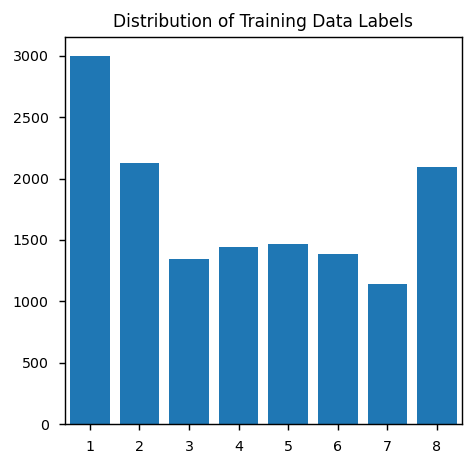

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
y_counts = np.bincount(Y_train)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Training Data Labels")
plt.show()

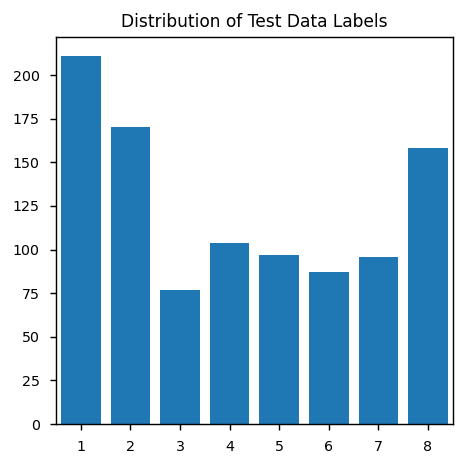

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
y_counts = np.bincount(Y_dev)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Test Data Labels")
plt.show()

# Model Selection

In [18]:
f1labels = ["F1 " + labels[i+1] for i in range(len(labels))]
rclabels = ["Recall " + labels[i+1] for i in range(len(labels))]
pclabels = ["Precision " + labels[i+1] for i in range(len(labels))]
numlabels = [i+1 for i in range(len(labels))]


In [19]:
def get_scores(preds, label, cv_score, truth=Y_dev):
    return pd.DataFrame([[label,
               accuracy_score(truth, preds),
               recall_score(truth, preds, average='macro'),
               precision_score(truth, preds, average='macro'),
               f1_score(truth, preds, average='macro', ),
               cv_score,
               *(f1_score(truth, preds, average=None, labels=numlabels)),
               *(recall_score(truth, preds, average=None, labels=numlabels)),
               *(precision_score(truth, preds, average=None, labels=numlabels)),
            ]],
             columns=["Model", "Accuracy", "Recall", "Precision", "F1", "Train Accuracy", *f1labels, *rclabels, *pclabels ],
             index=[label]
        )
    
def print_scores(preds, gs_, Y=Y_dev):
    
    print("Best parameters: ")
    print(gs_.best_params_)
    print("------------------------")

    print("Accuracy:         ", round(accuracy_score(Y_dev, preds),4))
    print("Macro F1:         ", round(f1_score(Y_dev, preds, average='macro'),4))
    print("Macro Recall:     ", round(recall_score(Y_dev, preds, average='macro'),4))
    print("Macro Precision:  ", round(precision_score(Y_dev, preds, average='macro'),4))
    print("Best Train Score: ", round(gs_.best_score_,4))

    return

def plot_cm(preds, title, Y=Y_dev):
    cm_ = confusion_matrix(Y, preds)
    df_cm = pd.DataFrame(cm_, index=numlabels, columns=numlabels)
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues", fmt="d")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    
    plt.title("Confusion Matrix: "+title, fontsize=12)
    
    
    plt.show()
    fn = './imgs03/ConfusionMatrix_' + title.replace(' ','-') + '.png'
    fig.savefig(fn, bbox_inches='tight', transparent=True)
    
    return



In [20]:
score_func = 'accuracy'

## Baseline KNN

In [21]:
pipe_knn = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', KNeighborsClassifier()),  # 
])

grid_knn = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
}

gs_knn = GridSearchCV(pipe_knn, grid_knn, n_jobs=-1, cv=10, scoring=score_func)
gs_knn.fit(X_train, Y_train)
gs_knn_pred = gs_knn.predict(X_dev)


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.289
Macro F1:          0.2271
Macro Recall:      0.2322
Macro Precision:   0.2582
Best Train Score:  0.269


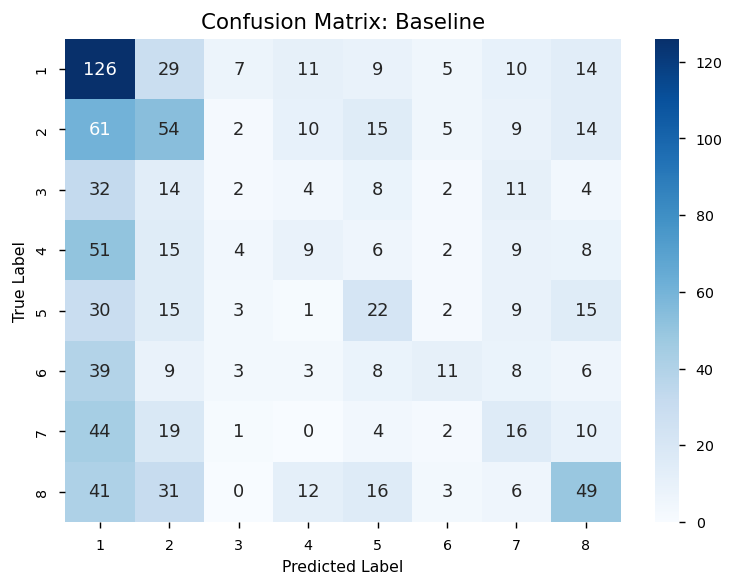

In [22]:
print_scores(gs_knn_pred, gs_knn)
scores = get_scores(gs_knn_pred, "KNN Baseline", gs_knn.best_score_)
plot_cm(gs_knn_pred, "Baseline")

## KNN Optimized

In [23]:
pipe_knno = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('knn', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knno = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "knn__n_neighbors": [20],
    "knn__metric": ['cosine'],
    
}

gs_knno = GridSearchCV(pipe_knno, grid_knno, n_jobs=-1, cv=10, scoring=score_func)
gs_knno.fit(X_train, Y_train)
gs_knno_pred = gs_knno.predict(X_dev)


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'knn__metric': 'cosine', 'knn__n_neighbors': 20}
------------------------
Accuracy:          0.303
Macro F1:          0.2431
Macro Recall:      0.2483
Macro Precision:   0.2755
Best Train Score:  0.3073


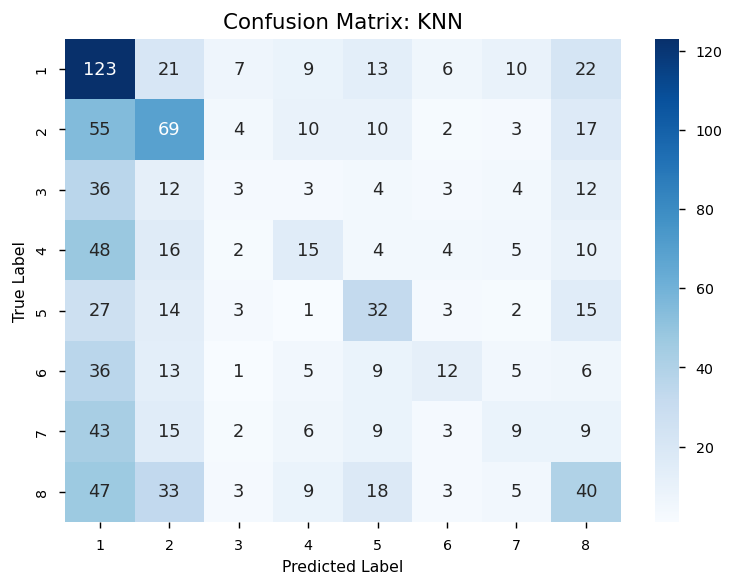

In [24]:
print_scores(gs_knno_pred, gs_knno)
scores = pd.concat([scores,get_scores(gs_knno_pred, "KNN", gs_knno.best_score_)])
plot_cm(gs_knno_pred, "KNN")

## MNB

In [25]:
pipe_mnb = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', MultinomialNB()),  # 
])

## Uses values of default params as grid search values
grid_mnb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "classifier__alpha": [.5]
}

gs_mnb = GridSearchCV(pipe_mnb, grid_mnb, n_jobs=-1, cv=10, scoring=score_func)

gs_mnb.fit(X_train, Y_train)
gs_mnb_pred = gs_mnb.predict(X_dev)


In [26]:
print_scores(gs_mnb_pred, gs_mnb)
scores = pd.concat([scores,get_scores(gs_mnb_pred, "MultinomialNB", gs_mnb.best_score_)])


Best parameters: 
{'classifier__alpha': 0.5, 'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.378
Macro F1:          0.3347
Macro Recall:      0.3311
Macro Precision:   0.3672
Best Train Score:  0.3698


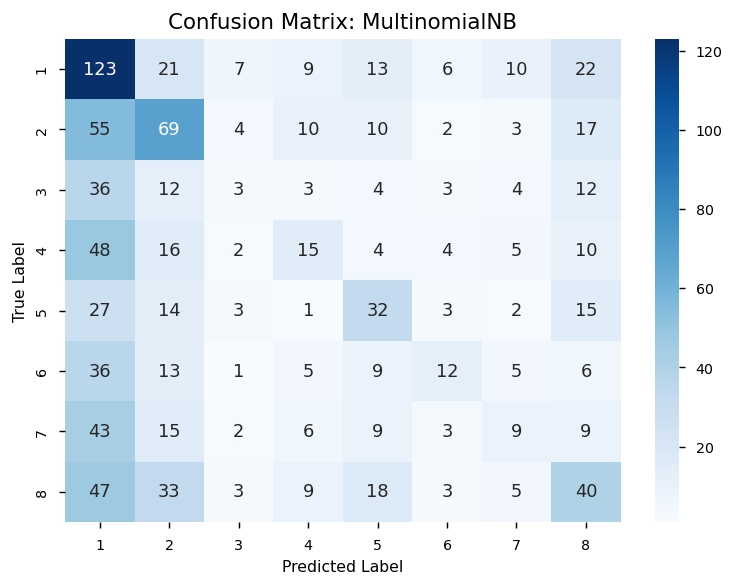

In [27]:
plot_cm(gs_knno_pred, "MultinomialNB")

## SGD

In [28]:
pipe_sgd = Pipeline([
    ('count', CountVectorizer()),
    ('sgd', SGDClassifier(random_state=RANDOM_STATE, max_iter=3000)),
])

grid_sgd = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "sgd__loss": ['log'],    
}

gs_sgd = GridSearchCV(pipe_sgd, grid_sgd, n_jobs=-1, cv=10, scoring=score_func)
gs_sgd.fit(X_train, Y_train)

gs_sgd_pred = gs_sgd.predict(X_dev)



In [29]:
print_scores(gs_sgd_pred, gs_sgd)
get_scores(gs_sgd_pred, "SGD", gs_sgd.best_score_)

scores = pd.concat([scores,get_scores(gs_sgd_pred, "SGDClassifier", gs_sgd.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'sgd__loss': 'log'}
------------------------
Accuracy:          0.383
Macro F1:          0.3563
Macro Recall:      0.3515
Macro Precision:   0.3752
Best Train Score:  0.3775


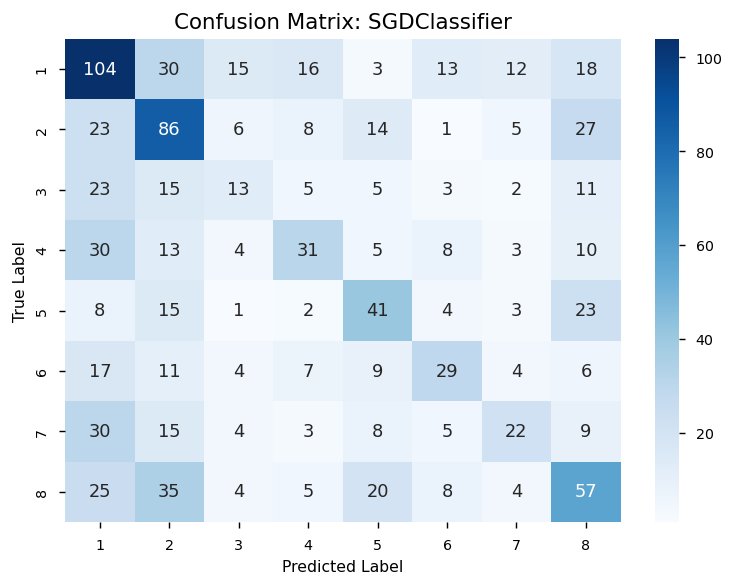

In [30]:
plot_cm(gs_sgd_pred, "SGDClassifier")

## LR

In [31]:
pipe_lr = Pipeline([
    ('count', CountVectorizer()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)),
])

grid_lr = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "lr__solver": ['lbfgs'],
    "lr__multi_class": ['multinomial'],
    #"lr__": [],
}

gs_lr = GridSearchCV(pipe_lr, grid_lr, n_jobs=-1, cv=10, scoring=score_func)

gs_lr.fit(X_train, Y_train)
gs_lr_pred = gs_lr.predict(X_dev)



In [32]:
print_scores(gs_lr_pred, gs_lr)
get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)

scores = pd.concat([scores,get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs'}
------------------------
Accuracy:          0.366
Macro F1:          0.3435
Macro Recall:      0.3401
Macro Precision:   0.3547
Best Train Score:  0.3768


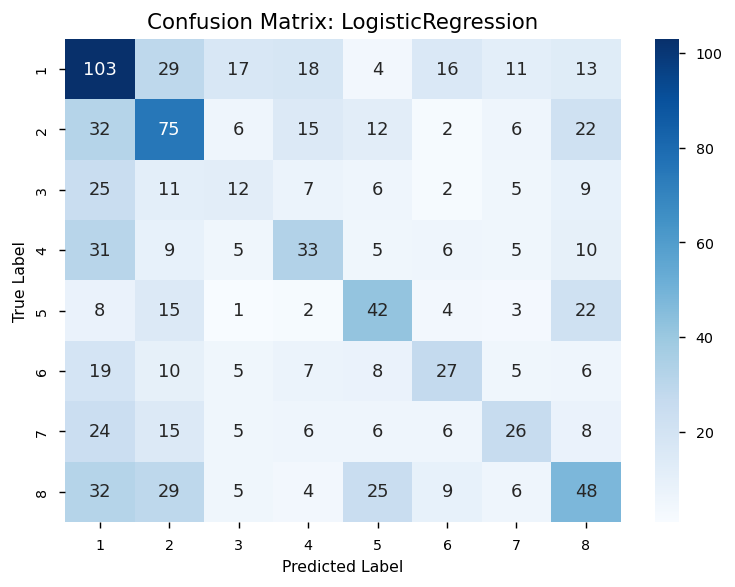

In [33]:
plot_cm(gs_lr_pred, "LogisticRegression")

## DT

In [34]:

pipe_dt = Pipeline([
    ('count', CountVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

grid_dt = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None],
    "dt__criterion": ['gini'],
    #"dt__": [],
    
}

gs_dt = GridSearchCV(pipe_dt, grid_dt, n_jobs=-1, cv=10, scoring=score_func)

gs_dt.fit(X_train, Y_train)
gs_dt_pred = gs_dt.predict(X_dev)


In [35]:
print_scores(gs_dt_pred, gs_dt)
get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)

scores = pd.concat([scores,get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': 'english', 'dt__criterion': 'gini'}
------------------------
Accuracy:          0.32
Macro F1:          0.286
Macro Recall:      0.2837
Macro Precision:   0.3016
Best Train Score:  0.2853


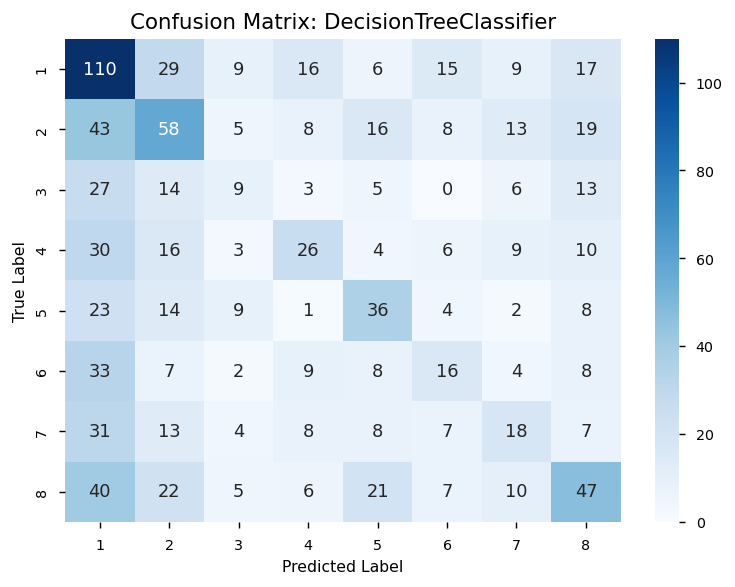

In [36]:
plot_cm(gs_dt_pred, "DecisionTreeClassifier")

## GB

In [38]:

pipe_gb = Pipeline([
    ('count', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

grid_gb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "gb__loss": ['deviance'],
    "gb__n_estimators": [200],
    "gb__learning_rate": [.25],    
}

gs_gb = GridSearchCV(pipe_gb, grid_gb, n_jobs=-1, cv=10, scoring=score_func)

gs_gb.fit(X_train, Y_train)
gs_gb_pred = gs_gb.predict(X_dev)


In [39]:
print_scores(gs_gb_pred, gs_gb)
get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_gb.best_score_)

scores = pd.concat([scores,get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_gb.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'gb__learning_rate': 0.25, 'gb__loss': 'deviance', 'gb__n_estimators': 200}
------------------------
Accuracy:          0.339
Macro F1:          0.2964
Macro Recall:      0.2903
Macro Precision:   0.3363
Best Train Score:  0.3498


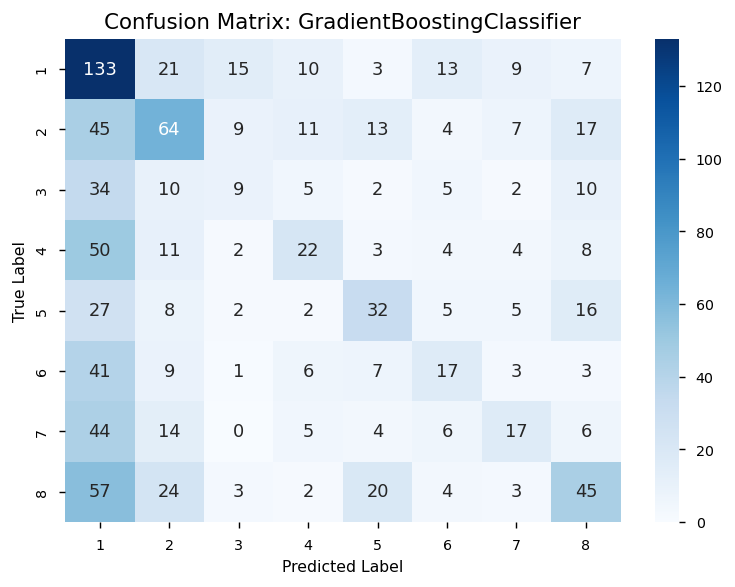

In [40]:
plot_cm(gs_gb_pred, "GradientBoostingClassifier")

## SVM

In [41]:

pipe_sv = Pipeline([
    ('count', CountVectorizer()),
    ('svc', SVC(random_state=RANDOM_STATE)),
])

grid_sv = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "svc__kernel": ['linear'],
    "svc__decision_function_shape": ['ovo'],
}

gs_sv = GridSearchCV(pipe_sv, grid_sv, n_jobs=-1, cv=10, scoring=score_func)

gs_sv.fit(X_train, Y_train)
gs_sv_pred = gs_sv.predict(X_dev)


In [42]:
print_scores(gs_sv_pred, gs_sv)
get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)

scores = pd.concat([scores,get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'svc__decision_function_shape': 'ovo', 'svc__kernel': 'linear'}
------------------------
Accuracy:          0.372
Macro F1:          0.3421
Macro Recall:      0.338
Macro Precision:   0.3557
Best Train Score:  0.3736


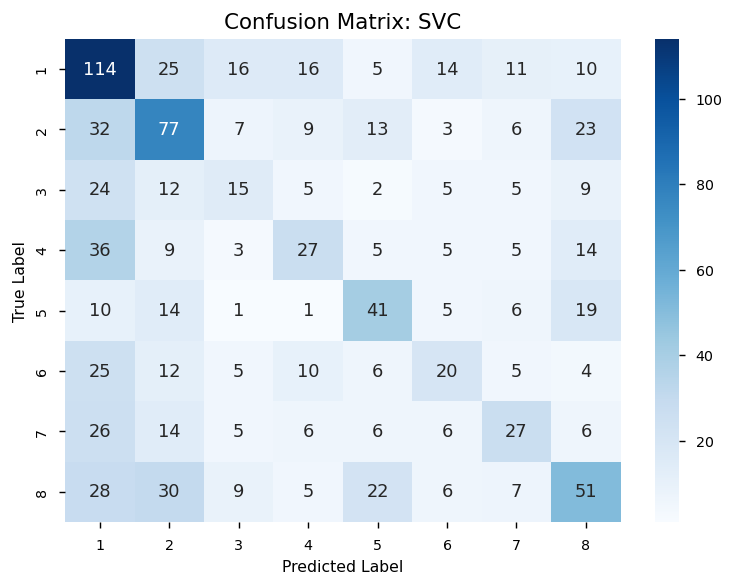

In [43]:
plot_cm(gs_sv_pred, "SVC")

## VotingClassifier

In [44]:
vc_ = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE)), 
                ('nb', MultinomialNB()),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
                ('sv', SVC(random_state=RANDOM_STATE))
               ],
    voting='hard'
)

vc_pipe_ = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc_)
    ])


grid_vc_ = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc_ = GridSearchCV(vc_pipe_, grid_vc_, n_jobs=-1, cv=10, scoring=score_func)

gs_vc_.fit(X_train, Y_train)
gs_vc_pred_ = gs_vc_.predict(X_dev)



In [45]:
print_scores(gs_vc_pred_, gs_vc_)
get_scores(gs_vc_pred_, "VotingClassifier_NoTuning", gs_vc_.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred_, "VotingClassifier_NoTuning", gs_vc_.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.384
Macro F1:          0.3352
Macro Recall:      0.3289
Macro Precision:   0.4013
Best Train Score:  0.3761


### Using optimized base estimators

In [46]:
vc = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial')), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE, loss='log')), 
                ('nb', MultinomialNB(alpha=.5)),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, loss='deviance', n_estimators=200, learning_rate=.25)),
                ('sv', SVC(random_state=RANDOM_STATE, kernel='linear', decision_function_shape='ovo'))
               ],
    voting='hard'
)

vc_pipe = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc)
    ])


grid_vc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc = GridSearchCV(vc_pipe, grid_vc, n_jobs=-1, cv=10, scoring=score_func)

gs_vc.fit(X_train, Y_train)
gs_vc_pred = gs_vc.predict(X_dev)



In [47]:
print_scores(gs_vc_pred, gs_vc)
get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.389
Macro F1:          0.358
Macro Recall:      0.3504
Macro Precision:   0.3868
Best Train Score:  0.3828


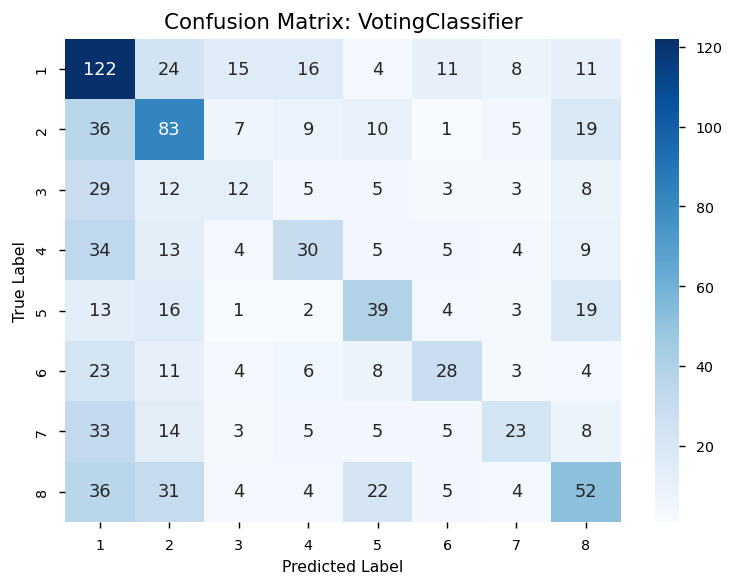

In [48]:
plot_cm(gs_vc_pred, "VotingClassifier")

## RF

In [49]:

pipe_rf = Pipeline([
    ('count', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
])

grid_rf = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "rf__n_estimators": [200],
    "rf__criterion": ['gini'],

}

gs_rf = GridSearchCV(pipe_rf, grid_rf, n_jobs=-1, cv=10, scoring=score_func)

gs_rf.fit(X_train, Y_train)
gs_rf_pred = gs_rf.predict(X_dev)


In [50]:
print_scores(gs_rf_pred, gs_rf)
get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)

scores = pd.concat([scores,get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'rf__criterion': 'gini', 'rf__n_estimators': 200}
------------------------
Accuracy:          0.356
Macro F1:          0.2945
Macro Recall:      0.2975
Macro Precision:   0.3232
Best Train Score:  0.348


In [51]:
scores.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

,Model,Accuracy,Recall,Precision,F1,Train Accuracy,F1 Anger,F1 Anticipation,F1 Digust,F1 Fear,...,Recall Surprise,Recall Trust,Precision Anger,Precision Anticipation,Precision Digust,Precision Fear,Precision Joy,Precision Sadness,Precision Surprise,Precision Trust
0,VotingClassifier,0.389,0.350417,0.386780,0.358046,0.382786,0.454376,0.443850,0.188976,0.331492,...,0.239583,0.329114,0.374233,0.406863,0.240000,0.389610,0.397959,0.451613,0.433962,0.400000
1,VotingClassifier_NoTuning,0.384,0.328935,0.401265,0.335230,0.376143,0.462250,0.425414,0.137255,0.246753,...,0.208333,0.297468,0.342466,0.401042,0.280000,0.380000,0.434783,0.452830,0.487805,0.431193
2,SGDClassifier,0.383,0.351453,0.375172,0.356262,0.377500,0.441614,0.441026,0.203125,0.342541,...,0.229167,0.360759,0.400000,0.390909,0.254902,0.402597,0.390476,0.408451,0.400000,0.354037
3,MultinomialNB,0.378,0.331077,0.367160,0.334717,0.369786,0.463415,0.407821,0.157895,0.261905,...,0.166667,0.360759,0.366391,0.388298,0.243243,0.343750,0.455556,0.375000,0.363636,0.401408
4,SVC,0.372,0.338031,0.355697,0.342103,0.373571,0.450593,0.424242,0.217391,0.295082,...,0.281250,0.322785,0.386441,0.398964,0.245902,0.341772,0.410000,0.312500,0.375000,0.375000
5,LogisticRegression,0.366,0.340056,0.354659,0.343484,0.376786,0.424742,0.413223,0.180451,0.336735,...,0.270833,0.303797,0.375912,0.388601,0.214286,0.358696,0.388889,0.375000,0.388060,0.347826
6,RandomForestClassifier,0.356,0.297450,0.323168,0.294450,0.348000,0.448276,0.403270,0.040816,0.263158,...,0.218750,0.392405,0.352304,0.375635,0.095238,0.416667,0.402299,0.279070,0.269231,0.394904
7,GradientBoostingClassifier,0.339,0.290302,0.336333,0.296417,0.349786,0.414330,0.386707,0.152542,0.263473,...,0.177083,0.284810,0.308585,0.397516,0.219512,0.349206,0.380952,0.293103,0.340000,0.401786
8,DecisionTreeClassifier,0.320,0.283675,0.301621,0.285990,0.285286,0.401460,0.338192,0.146341,0.287293,...,0.187500,0.297468,0.326409,0.335260,0.195652,0.337662,0.346154,0.253968,0.253521,0.364341
9,KNN,0.303,0.248344,0.275466,0.243139,0.307286,0.392971,0.380165,0.058824,0.185185,...,0.093750,0.253165,0.296386,0.357513,0.120000,0.258621,0.323232,0.333333,0.209302,0.305344


In [52]:
scores.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)\
        .to_csv('scores03.csv', index=False)

In [53]:
scores.loc[scores['Model']=='VotingClassifier',:].T

,VotingClassifier
Model,VotingClassifier
Accuracy,0.389
Recall,0.350417
Precision,0.38678
F1,0.358046
Train Accuracy,0.382786
F1 Anger,0.454376
F1 Anticipation,0.44385
F1 Digust,0.188976
F1 Fear,0.331492
